1. Scrapping the data from webapp: "https://www.airlinequality.com/"
2. Will pull only the relevant Data from the web app

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import nltk
import os
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
import re

Web Scrapping the Data and creating the data frame

In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 12
page_size = 100

reviews = []
recommended = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())

    for para in parsed_content.find_all('td', class_=["review-value rating-yes", "review-value rating-no"]):
        recommended.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")


Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews
Scraping page 11
   ---> 1100 total reviews
Scraping page 12
   ---> 1200 total reviews


In [3]:
df_temp, df, df_recommended = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
df_temp['reviews'] = reviews
df_recommended['recommended'] = recommended
df_temp[['if_verfied', 'comment']] = df_temp['reviews'].str.split('\|', expand=True)
df['comment'] = df_temp['comment']

df.head()

,comment
0,Flown with BA four times. As an anxious trave...
1,You may never see your refund. I cancelled ...
2,Cargo service: that's how I felt in the A380 ...
3,Inefficient and slow airport operation. Resti...
4,The customer service is one of the worst I h...


### Sentiment Analysis

In [4]:
# Specify the custom path where you want to download the data
custom_path = r"C:\Users\thehu\Desktop\Data-Engineering-Projects\Airline Data Analysis" # Replace with your desired path

# Set the NLTK_DATA environment variable
os.environ['NLTK_DATA'] = custom_path

# Download the 'stopwords' dataset to the custom directory
nltk.download('stopwords', download_dir=custom_path)
nltk.download('wordnet', download_dir=custom_path)
nltk.data.path.append(custom_path)

# Load the English stopwords
english_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thehu\Desktop\Data-Engineering-
[nltk_data]     Projects\Airline Data Analysis...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\thehu\Desktop\Data-Engineering-
[nltk_data]     Projects\Airline Data Analysis...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
def process_comment(comment):
    # Removing punctuation and special characters
    comment = re.sub(r'[^A-Za-z0-9\s]', '', comment)
    words = comment.lower().split() # Splitting the word
    filtered_words = [word for word in words if word not in english_stopwords] # Remove StopWords
    # Using PorterStreamer
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_words]
    word_counts = {word: lemmatized_tokens.count(word) for word in lemmatized_tokens} # counting the filtered words
    return word_counts
df_counts = pd.DataFrame()
df_counts = df['comment'].apply(process_comment).apply(pd.Series).fillna(0)
result_df = pd.concat([df, df_counts], axis = 1)

In [6]:
df_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Columns: 7958 entries, flown to restart
dtypes: float64(7958)
memory usage: 72.9 MB


In [31]:
df_final = pd.concat([df_counts, df_recommended], axis = 1)
# df_final['recommended'] = df_final['recommended'].replace({'yes': 1, 'no': 0})
df_final.head()

,flown,ba,four,time,anxious,traveller,cant,recommend,enough,constant,...,fransisco,appr,junk,bulkier,reminding,argentinian,stodgy,riyadh,restart,recommended
0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,yes
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no
2,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no
4,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming df_final is your DataFrame and 'recommended' is the target column

# Split the data into features (X) and target (y)
X = df_final.iloc[:, :-1]
# y will contain only the last column
y = df_final.iloc[:, -1]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

def evaluate_classifier(classifier, X_train, X_test, y_train, y_test):
    # Train the classifier
    classifier.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = classifier.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='positive', average='micro')
    recall = recall_score(y_test, y_pred, pos_label='positive', average='micro')
    f1 = f1_score(y_test, y_pred, pos_label='positive', average='micro')
    
    return accuracy, precision, recall, f1

# Create a dictionary of classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

# Initialize the results dictionary
results = {}

# Evaluate each classifier
for name, clf in classifiers.items():
    accuracy, precision, recall, f1 = evaluate_classifier(clf, X_train, X_test, y_train, y_test)
    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }


c:\Users\thehu\.conda\envs\airplane-DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1583: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\thehu\.conda\envs\airplane-DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1583: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\thehu\.conda\envs\airplane-DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1583: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\thehu\.conda\envs\airplane-DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1583: User

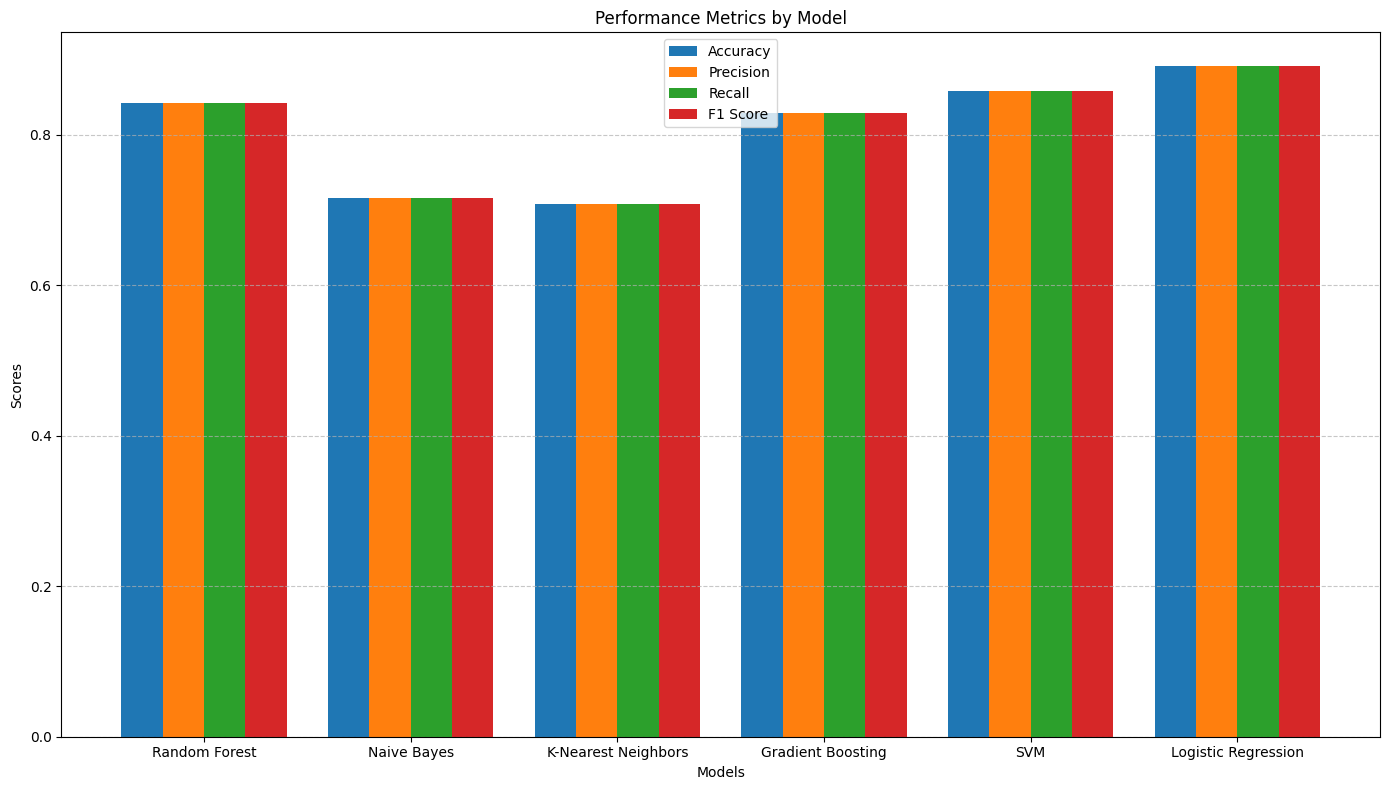

In [33]:
models = list(results.keys())
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
metric_values = {metric: [results[model].get(metric, 0) for model in models] for metric in metrics}

# Plotting
x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 8))

bars = []
for i, metric in enumerate(metrics):
    bars.append(ax.bar(x + i*width, metric_values[metric], width, label=metric))

# Adding some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics by Model')
ax.set_xticks(x + width*(len(metrics) - 1) / 2)
ax.set_xticklabels(models)
ax.legend()

# Adding gridlines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

# Display the plot
plt.show()

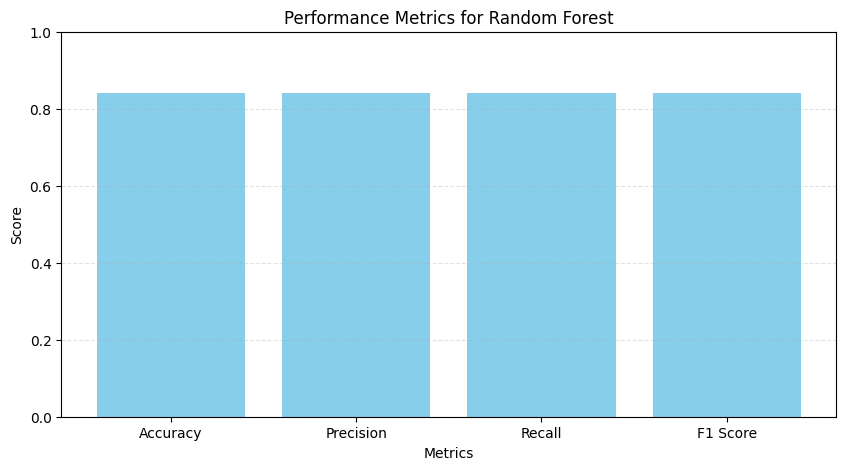

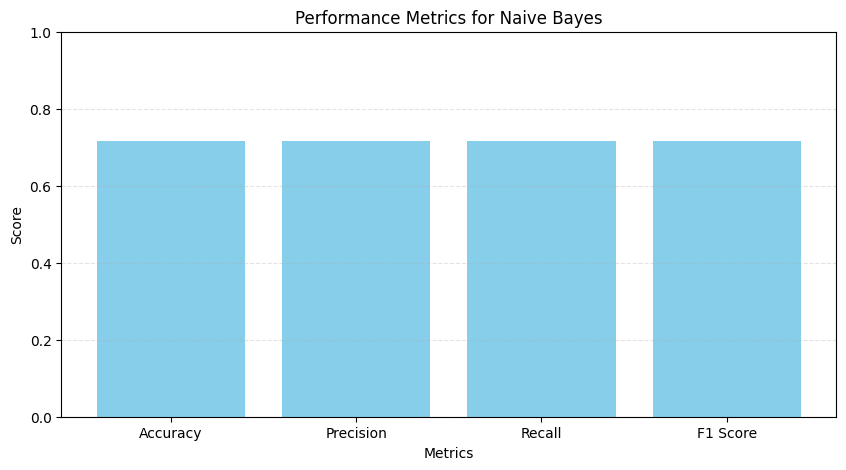

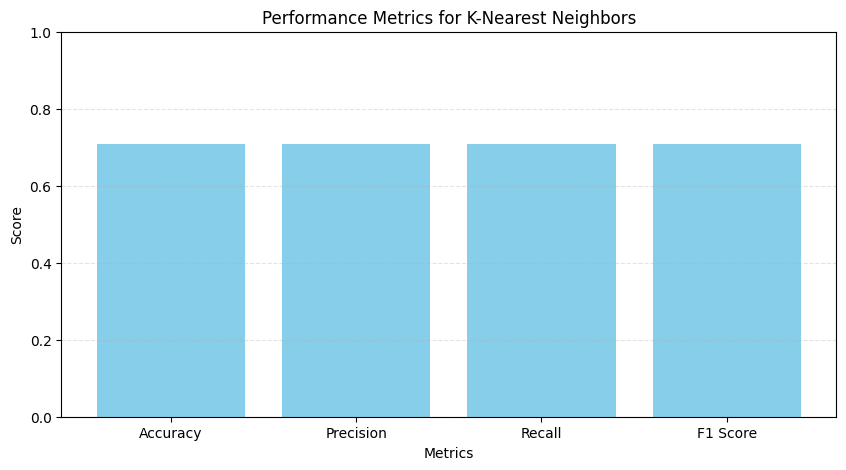

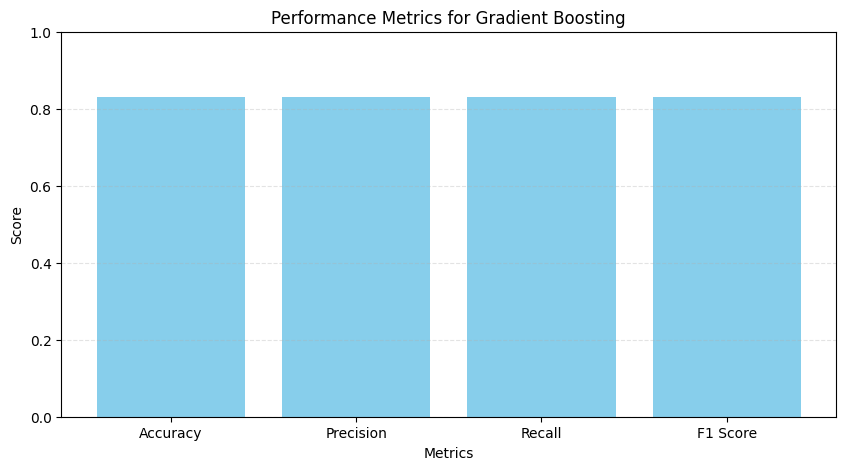

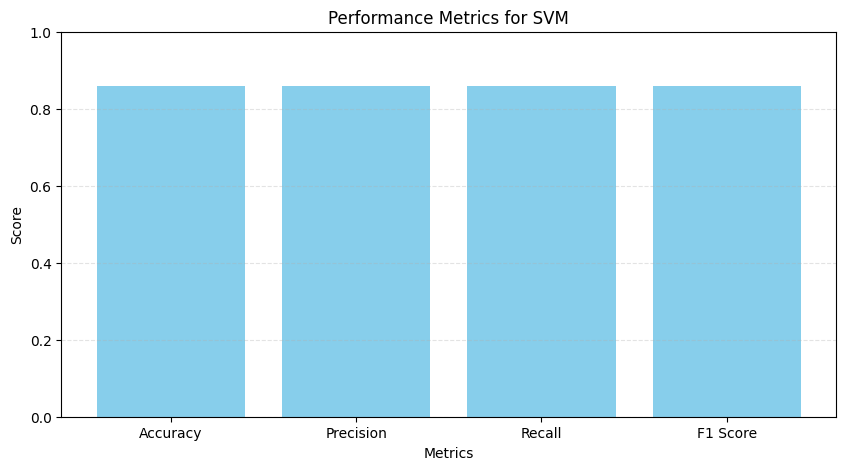

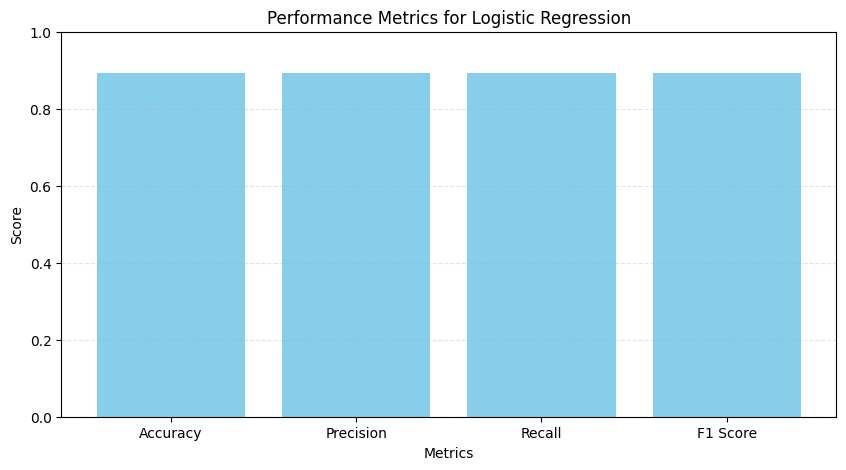

In [34]:
for name, metrics in results.items():
# Create lists for plotting
    metric_names = list(metrics.keys())
    metric_values = list(metrics.values())

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.bar(metric_names, metric_values, color='skyblue')
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title(f'Performance Metrics for {name}')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.35)

    # Display the plot
    plt.show()

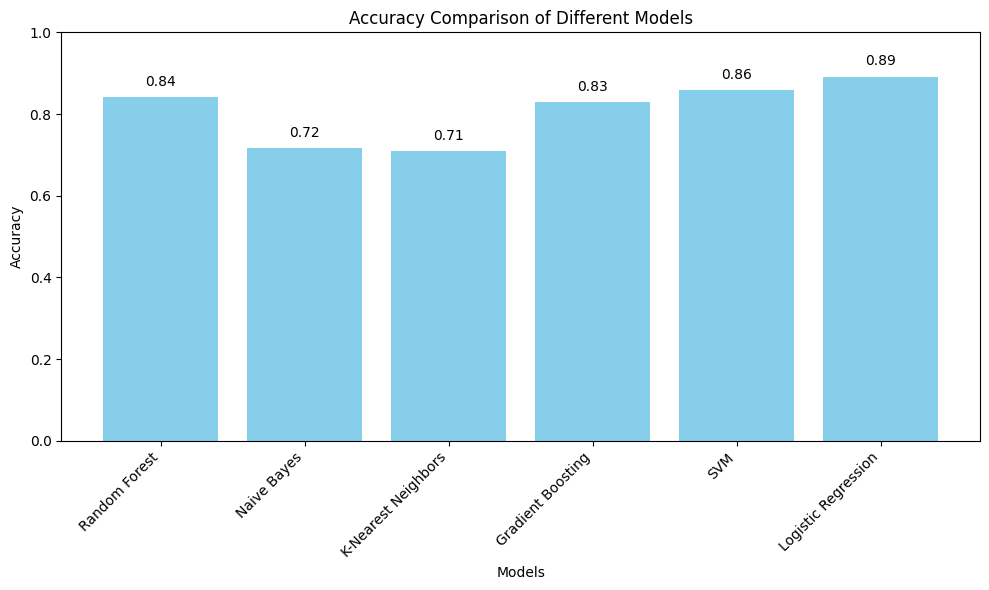

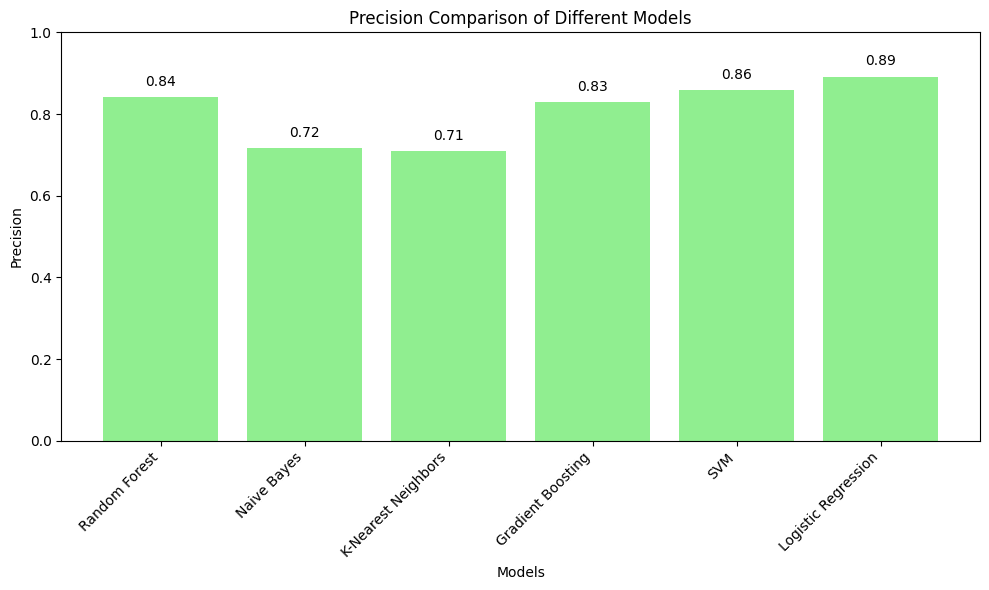

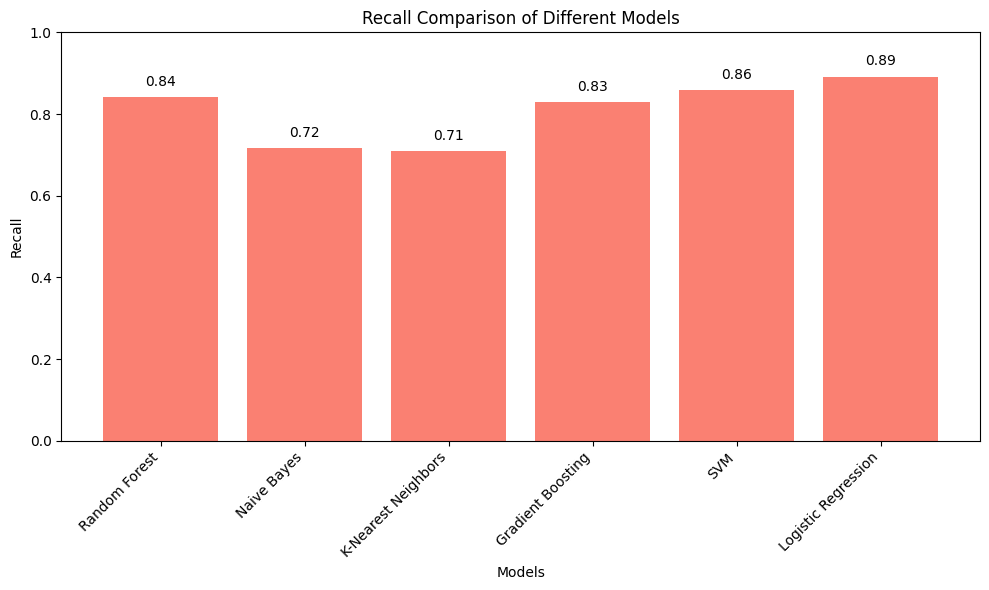

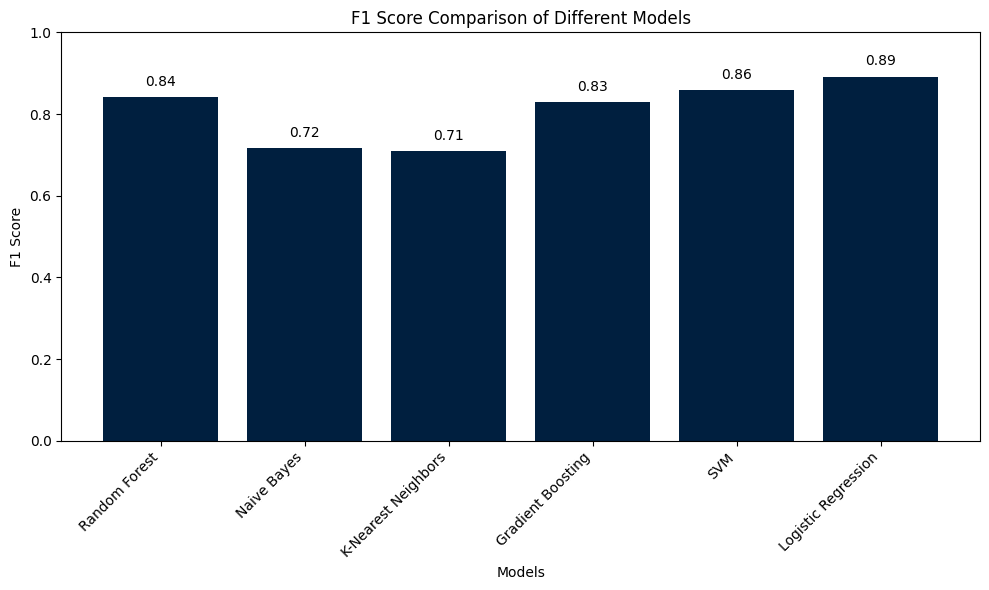

In [35]:
# For accuracy
models = list(results.keys())
accuracy_values = [results[model]["Accuracy"] for model in models]

# Plotting Accuracy
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(models, accuracy_values, color='skyblue')

# Adding some text for labels, title, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison of Different Models')
ax.set_ylim(0, 1)  # Set y-axis limit to [0, 1] for better visualization

# Adding value labels on top of the bars
for i, v in enumerate(accuracy_values):
    ax.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom')

# Display the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Extracting Precision metric
precision_values = [results[model]["Precision"] for model in models]

# Plotting Precision
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(models, precision_values, color='lightgreen')

# Adding some text for labels, title, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Precision')
ax.set_title('Precision Comparison of Different Models')
ax.set_ylim(0, 1)  # Set y-axis limit to [0, 1] for better visualization

# Adding value labels on top of the bars
for i, v in enumerate(precision_values):
    ax.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom')

# Display the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Extracting Recall metric
recall_values = [results[model]["Recall"] for model in models]

# Plotting Recall
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(models, recall_values, color='salmon')

# Adding some text for labels, title, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Recall')
ax.set_title('Recall Comparison of Different Models')
ax.set_ylim(0, 1)  # Set y-axis limit to [0, 1] for better visualization

# Adding value labels on top of the bars
for i, v in enumerate(recall_values):
    ax.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom')

# Display the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Extracting F1 Score metric
f1_score_values = [results[model]["F1 Score"] for model in models]

# Plotting F1 Score
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(models, f1_score_values, color='#001f3f')

# Adding some text for labels, title, etc.
ax.set_xlabel('Models')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score Comparison of Different Models')
ax.set_ylim(0, 1)  # Set y-axis limit to [0, 1] for better visualization

# Adding value labels on top of the bars
for i, v in enumerate(f1_score_values):
    ax.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom')

# Display the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
